In [1]:
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid",context='talk', font_scale=1.1)
%matplotlib inline

# rest
import scipy as scp
import pandas as pd
import copy as cp
from tqdm import tqdm 
from itertools import cycle
import numpy as np
from scipy.signal import correlate2d

In [2]:
fec_pars = {'A': {'OP50': [22.65, 68.45, 57.05, 33.4,  4.97], 'Novo': [11.66, 62.53, 47.13, 13.94,  0.72]},
            'C': {'OP50': [19.8 , 60.3 , 43.02, 19.9,  6.6], 'Novo': [16.88, 80.77, 77.7 , 16.28,  1.4]}}

mf_prob = {'A': {'OP50': 0.11, 'Novo': 0.83}, 'C': {'OP50': 1.0, 'Novo': 1.0}}

In [3]:
class Population(object):
    
    def __init__(self, n0, consumption=0.0, r0=1000, α=False):
        self.pop = n0
        self.resource = r0
        self.α = α
        self.consumption = consumption
        self.diet_stat_pre = None
    
    @property
    def comb_f_mat(self):
        if self._diet != self.diet_stat_pre or not hasattr(self, 'f_mat_A'):
            self.f_mat_A = self.gen_fec_matrix('A', self.diet, 0.0415)
            self.f_mat_C = self.gen_fec_matrix('C', self.diet, 0.0415)
        return np.block([[self.f_mat_A, np.zeros((10,10))],
                        [np.zeros((10,10)), self.f_mat_C]])
        
    @property
    def diet(self):
        return self._diet
    
    @diet.setter
    def diet(self, d):
        if self.diet_stat_pre is None:
            self.diet_stat_pre = d
        else:
            self.diet_stat_pre = self._diet
        self._diet = d
        
    @property
    def u_mat(self):
        u_mat_A = self.generate_matrix(self.resource, self.diet, 'A')
        u_mat_C = self.generate_matrix(self.resource, self.diet, 'C')
        return (u_mat_A, u_mat_C)
    
    @property
    def comb_u_mat(self):
        u_A, u_C = self.u_mat
        comb_u_mat = np.block([[u_A, np.zeros((10,10))],
                               [np.zeros((10,10)), u_C]])
        return comb_u_mat
            
    @property
    def fund_mat(self):
        u_A, u_C = self.u_mat
        return (np.linalg.inv(np.identity(10) - u_A), np.linalg.inv(np.identity(10) - u_C))
    
    @property
    def growth_rate(self):
        fund_m = self.fund_mat
        return (np.linalg.eig(self.f_mat_A*fund_m[0])[0][0], np.linalg.eig(self.f_mat_C*fund_m[0])[0][0])
        
    @staticmethod
    def generate_matrix(r, diet, strain, r_min=100):
        U = np.identity(10) * 0
        γ_JE  = lambda r: 0.0415 if r > r_min else 0.0
        γ_DJ = lambda r: 0.0415 if r < r_min else 0.0
        γ_YD = lambda r: 0.0415 if r > r_min else 0.0

        γ_YJ = lambda r: 0.0415 if r > r_min else 0.0
        if diet=='Novo':
            if strain == 'C':
                γ_RAY = 0.14
            else:
                γ_RAY = 0.12
        else:
            γ_RAY = 0.1
        γ_RR = 0.0415
        γ_OR = 0.0415
        δ_E = lambda r: 1 if r > r_min else 0.9
        δ_J = lambda r: 1 if r > r_min else 0.9
        δ_Y = lambda r: 1 if r > r_min else 0.9
        δ_RA = lambda r: 1 if r > r_min else 0.9
        δ_OA = lambda r: 0.995 if r > r_min else 0.9
        δ_D = 1
        U[0][0] = δ_E(r) * (1 - γ_JE(r))
        # juvenile ra(r)tes
        U[1][0] = δ_E(r) * γ_JE(r)
        U[1][1] = δ_J(r) * (1 - γ_YJ(r)) * (1 - γ_DJ(r))
        # dauer rates
        U[2][1] = δ_J(r) * γ_DJ(r)
        U[2][2] = δ_D * (1 - γ_YD(r))
        # young adults
        U[3][1] = δ_J(r) * γ_YJ(r)
        U[3][2] = δ_D * γ_YD(r)
        U[3][3] = δ_Y(r) * (1 - γ_RAY)
        # reproducing adults
        U[4][3] = δ_Y(r) * γ_RAY
        U[4][4] = δ_RA(r) * (1 - γ_RR)
        U[5][4] = δ_RA(r) * γ_RR
        U[5][5] = δ_RA(r) * (1 - γ_RR)
        U[6][5] = δ_RA(r) * γ_RR
        U[6][6] = δ_RA(r) * (1 - γ_RR)
        U[7][6] = δ_RA(r) * γ_RR
        U[7][7] = δ_RA(r) * (1 - γ_RR)
        U[8][7] = δ_RA(r) * γ_RR
        U[8][8] = δ_RA(r) * (1 - γ_OR)
        # old adults
        U[9][8] = δ_RA(r) * γ_OR
        U[9][9] = δ_OA(r)

        return np.matrix(U)
    
    @staticmethod
    def gen_fec_matrix(strain, food_type, rate):
        """Generate fecundity matrix.

        Args:
            strain (str): A (RSC017) or C (RS5405)
            food_type (str): The bacterial diet (Novo or OP50)

        Returns:
            numpy matrix: fecundity values for each breeding developmental stage.
        """
        F = np.identity(10) * 0
        count = 0
        for i in np.arange(4, 9, 1):
            F[0][i] = rate*fec_pars[strain][food_type][count]
            count += 1
        return np.matrix(F)
    
    def predation(self):
        # C killing A
        juvenile_a = self.pop[1][0] 
        dauer_a = self.pop[2][0]
        predators_c = np.sum(self.pop[13:20])
        dauer_a -= self.α * mf_prob['C'][self.diet] * dauer_a * predators_c
        juvenile_a -= self.α * mf_prob['C'][self.diet] * juvenile_a * predators_c
        if dauer_a < 0:
            dauer_a = 0
        if juvenile_a < 0:
            juvenile_a = 0
        # A killing C
        juvenile_c = self.pop[11][0]
        dauer_c = self.pop[12][0]
        predators_a = np.sum(self.pop[3:10])
        dauer_c -= self.α * mf_prob['A'][self.diet] * dauer_c * predators_a
        juvenile_c -= self.α * mf_prob['A'][self.diet] * juvenile_c * predators_a
        if dauer_c < 0:
            dauer_c = 0
        if juvenile_c < 0:
            juvenile_c = 0
        self.pop[1][0]  = juvenile_a 
        self.pop[2][0]  = dauer_a
        self.pop[11][0] = juvenile_c
        self.pop[12][0] = dauer_c
    
    def take_a_step(self):
        self.pop = np.array(np.matmul(self.comb_u_mat + self.comb_f_mat, self.pop))
        if self.α > 0:
            self.predation()
        if self.consumption > 0.0:
            total_conusmers = self.pop[1][0] + np.sum(self.pop[3:10]) + self.pop[11][0] + np.sum(self.pop[13:20])
            self.resource -= self.consumption * total_conusmers
            if self.resource < 0:
                self.resource = 0
            
            
class MetaPopulation(object):
    
    kernel = np.array([[0, 1, 0],
                       [1,-4, 1],
                       [0, 1, 0]])
    
    def __init__(self, dim, pred_rate, c, r_rate=0, diff_boundary='symm'):
        self.dim = dim
        self.pred_rate = pred_rate
        self.cons_rate = c
        self.r_rate = r_rate
        self.diff_boundary = diff_boundary
        self.index = [(i,j) for i in range(dim) for j in range(dim)]
        self.fill_pop()
        
    def set_diet_comp(self, style):
        if style == 'OP50':
            diet_comp = {i:'OP50' for i in self.index}
        if style == 'Novo':
            diet_comp = {i:'Novo' for i in self.index}
        if style == 'quad_1':
            ind = [(i,j) for i in range(self.dim) if i < self.dim/2 for j in range(self.dim//2)] + [(i,j) for i in range(self.dim) if i >= self.dim/2 for j in np.arange(self.dim//2 , self.dim)]
            for i in self.index:
                diet_comp = {i:'OP50' if i in ind else 'Novo' for i in self.index}
        if style == 'quad_2':
            ind = [(i,j) for i in range(self.dim) if i < self.dim/2 for j in range(self.dim//2)] + [(i,j) for i in range(self.dim) if i >= self.dim/2 for j in np.arange(self.dim//2 , self.dim)]
            for i in self.index:
                diet_comp = {i:'Novo' if i in ind else 'OP50' for i in self.index}   
        if style == 'rand':
            ind = np.random.randint(0, len(self.index), size=len(self.index)//2)
            Novo_ind = [self.index[i] for i in ind]
            diet_comp = {i:'Novo' if i in Novo_ind else 'OP50' for i in self.index}
        for i in self.index:
            self.metapop[i].diet = diet_comp[i]
        
    def fill_pop(self):
        n0_empty = np.array([[0],  [0], [0], [0], [0], [0], [0], [0], [0], [0], [0],  [0], [0], [0], [0], [0], [0], [0], [0], [0]])
        self.metapop = {i:Population(n0_empty, consumption=self.cons_rate, α=self.pred_rate) for i in self.index}
        
    def add_pop(self, loc, strain):
        if strain == 'A':
            n0_A = np.array([[0], [50], [0], [0], [0], [0], [0], [0], [0], [0], [0],  [0], [0], [0], [0], [0], [0], [0], [0], [0]])
            self.metapop[loc] = Population(n0_A, consumption=self.cons_rate, α=self.pred_rate)
        else:
            n0_C = np.array([[0],  [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [50], [0], [0], [0], [0], [0], [0], [0], [0]])
            self.metapop[loc] = Population(n0_C, consumption=self.cons_rate, α=self.pred_rate)
            
    def reset_food(self, r0=1000):
        for i in self.index:
            self.metapop[i].resource = r0

    @property
    def daur_dist(self):
        dist_A = np.zeros((self.dim, self.dim))
        dist_C = np.zeros((self.dim, self.dim))
        for i in self.index:
            dist_A[i[0]][i[1]] = self.metapop[i].pop[2][0]
            dist_C[i[0]][i[1]] = self.metapop[i].pop[12][0]
        return dist_A, dist_C
    
    @property
    def r_dist(self):
        r_patt = np.zeros((self.dim, self.dim))
        for i in self.index:
            r_patt[i[0]][i[1]] = self.metapop[i].resource
        return r_patt
    
    @property
    def ra_dist(self):
        dist_A = np.zeros((self.dim, self.dim))
        dist_C = np.zeros((self.dim, self.dim))
        for i in self.index:
            dist_A[i[0]][i[1]] = np.sum(self.metapop[i].pop[4:9])
            dist_C[i[0]][i[1]] = np.sum(self.metapop[i].pop[14:19])
        return dist_A, dist_C
    
    def diffuse_dauer(self):
        a, c = self.daur_dist
        total = np.sum(a) + np.sum(c)
        if total >= 0:
            total_a = np.sum(a)
            total_c = np.sum(c)
            if total_a > 0:
                f_a = np.divide(a, total)
                diff_state_a = self.r_rate * correlate2d(f_a, self.kernel, mode='same', boundary=self.diff_boundary)
                f_a += diff_state_a
                f_a = total_a * f_a
                for i in self.index:
                    self.metapop[i].pop[2][0]  = f_a[i[0]][i[1]]
            if total_c > 0:
                f_c = np.divide(c, total)
                diff_state_c = self.r_rate * correlate2d(f_c, self.kernel, mode='same', boundary=self.diff_boundary)
                f_c += diff_state_c
                f_c = total_c * f_c
                for i in self.index:
                    self.metapop[i].pop[12][0] = f_c[i[0]][i[1]]

    def simulate_pops_one_step(self):
        for i in self.index:
            self.metapop[i].take_a_step()

In [20]:
att_rate = 1e-3
disp_rate = 0.01
dim = 10

metpop = MetaPopulation(dim, att_rate, 0.01, r_rate=disp_rate)
metpop.fill_pop()
metpop.add_pop((0,0), 'A')
# metpop.add_pop((9,9), 'A')
# metpop.add_pop((0,9), 'A')
# metpop.add_pop((9,0), 'A')
metpop.set_diet_comp('OP50')

dist_dauer = []
dis_RA = []
for i in range(800):
    # if not i%100:
    #     metpop.set_diet_comp('OP50')
    #     metpop.reset_food()
    metpop.simulate_pops_one_step()
    a, b = metpop.daur_dist
    dist_dauer.append((a, b))
    t1, t2 = metpop.ra_dist
    dis_RA.append((t1, t2))
    metpop.diffuse_dauer()

In [5]:
sns.set_theme(style="white",context='talk', font_scale=1.1)

Text(0.5, 0.92, 'Reproducing adults')

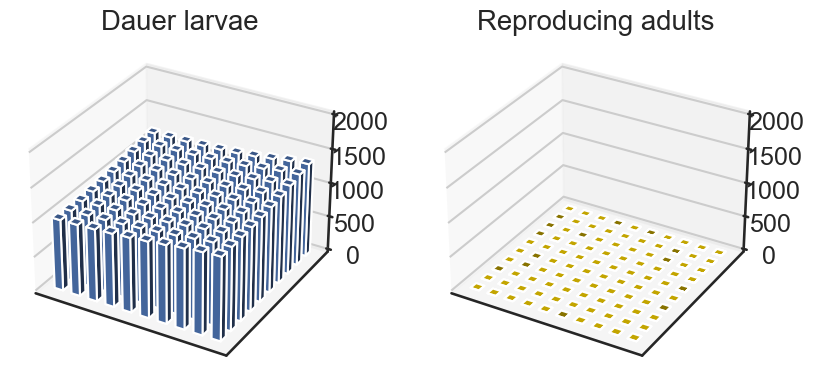

In [28]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(8, 8),
    constrained_layout=True, subplot_kw={'projection':'3d'}, gridspec_kw={'wspace':0.1})

dim = 10

xpos = np.arange(0, dim, 1)
ypos = np.arange(0, dim, 1)
xpos, ypos = np.meshgrid(xpos + 0.5, ypos + 0.5)
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros(dim * dim)
dx = np.ones(dim * dim) * 0.5
dy = np.ones(dim * dim) * 0.5
dz = dist_dauer[-1][0].flatten()
axes[0].bar3d(xpos, ypos, zpos, dx, dy, dz)


dz = dis_RA[-1][0].flatten()
axes[1].bar3d(xpos, ypos, zpos, dx, dy, dz, color='gold')

for i in axes:
    i.set_zlim(0, 2000)
    i.set(xticks=[], yticks=[])#, zticks=[])
    
    
    
axes[0].set_title('Dauer larvae')

axes[1].set_title('Reproducing adults')

In [30]:
count = 0
for i in range(800):
    fig, axes = plt.subplots(
        nrows=1,
        ncols=2,
        figsize=(8, 8),
        constrained_layout=True, subplot_kw={'projection':'3d'}, gridspec_kw={'wspace':0.1})

    dim = 10
    xpos = np.arange(0, dim, 1)
    ypos = np.arange(0, dim, 1)
    xpos, ypos = np.meshgrid(xpos + 0.5, ypos + 0.5)
    xpos = xpos.flatten()
    ypos = ypos.flatten()
    zpos = np.zeros(dim * dim)
    dx = np.ones(dim * dim) * 0.5
    dy = np.ones(dim * dim) * 0.5
    dz = dist_dauer[i][0].flatten()
    axes[0].bar3d(xpos, ypos, zpos, dx, dy, dz)
    dz = dis_RA[i][0].flatten()
    axes[1].bar3d(xpos, ypos, zpos, dx, dy, dz, color='gold')
    for i in axes:
        i.set_zlim(0, 2000)
        i.set(xticks=[], yticks=[])#, zticks=[])
        #i.set_zlim(0, )
    axes[0].set_title('Dauer larvae')

    axes[1].set_title('Reproducing adults')
    plt.savefig('./figures/t_series/OP50_1A_bar/d4_'+str(count)+'.jpeg', bbox_inches='tight', dpi=200)
    plt.close()
    count += 1

In [4]:
att_rate = 1e-3
disp_rate = 0.01
dim = 10

metpop = MetaPopulation(dim, att_rate, 0.01, r_rate=disp_rate)
metpop.fill_pop()
metpop.add_pop((0,0), 'A')
metpop.add_pop((9,9), 'A')
metpop.add_pop((0,9), 'C')
metpop.add_pop((9,0), 'C')
metpop.set_diet_comp('OP50')

dist_dauer = []
dis_RA = []
for i in range(800):
    # if not i%100:
    #     metpop.set_diet_comp('OP50')
    #     metpop.reset_food()
    metpop.simulate_pops_one_step()
    a, b = metpop.daur_dist
    dist_dauer.append((a, b))
    t1, t2 = metpop.ra_dist
    dis_RA.append((t1, t2))
    metpop.diffuse_dauer()

Text(0.5, 0.92, 'Reproducing adults (NP)')

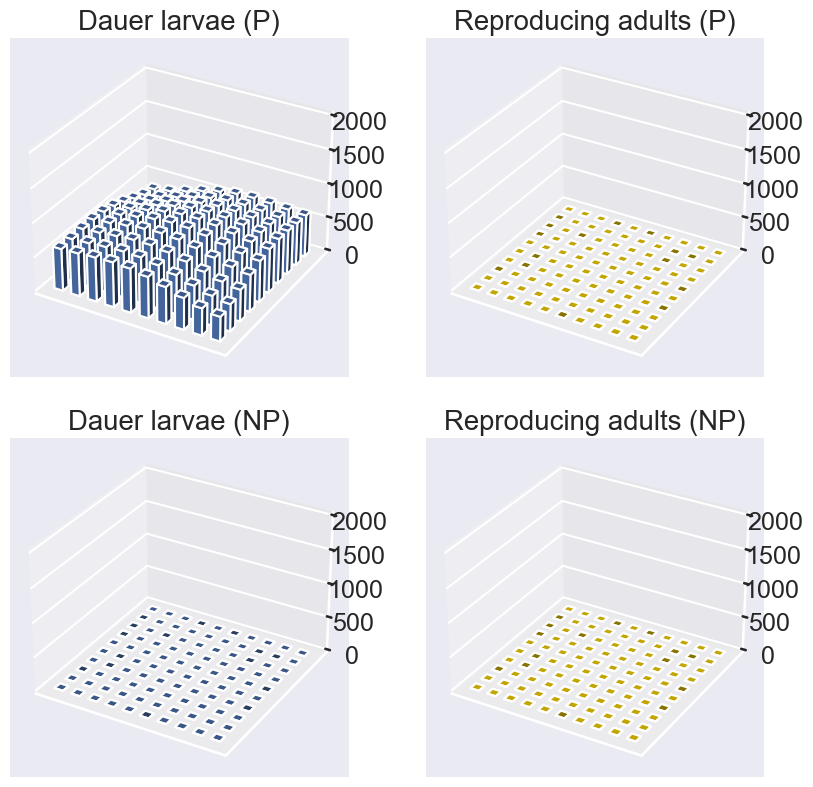

In [10]:
fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(8, 8),
    constrained_layout=True, subplot_kw={'projection':'3d'}, gridspec_kw={'wspace':0.1})

axes = axes.flatten()

dim = 10

xpos = np.arange(0, dim, 1)
ypos = np.arange(0, dim, 1)
xpos, ypos = np.meshgrid(xpos + 0.5, ypos + 0.5)
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros(dim * dim)
dx = np.ones(dim * dim) * 0.5
dy = np.ones(dim * dim) * 0.5
dz = dist_dauer[-1][0].flatten()
axes[0].bar3d(xpos, ypos, zpos, dx, dy, dz)
dz = dis_RA[-1][0].flatten()
axes[1].bar3d(xpos, ypos, zpos, dx, dy, dz, color='gold')


dz = dist_dauer[-1][1].flatten()
axes[2].bar3d(xpos, ypos, zpos, dx, dy, dz)
dz = dis_RA[-1][1].flatten()
axes[3].bar3d(xpos, ypos, zpos, dx, dy, dz, color='gold')

for i in axes:
    i.set_zlim(0, 2000)
    i.set(xticks=[], yticks=[])#, zticks=[])

    
axes[0].set_title('Dauer larvae (P)')
axes[1].set_title('Reproducing adults (P)')

axes[2].set_title('Dauer larvae (NP)')
axes[3].set_title('Reproducing adults (NP)')

In [11]:
count = 0
for i in range(800):
    fig, axes = plt.subplots(
        nrows=2,
        ncols=2,
        figsize=(8, 8),
        constrained_layout=True, subplot_kw={'projection':'3d'}, gridspec_kw={'wspace':0.1})

    axes = axes.flatten()

    dim = 10

    xpos = np.arange(0, dim, 1)
    ypos = np.arange(0, dim, 1)
    xpos, ypos = np.meshgrid(xpos + 0.5, ypos + 0.5)
    xpos = xpos.flatten()
    ypos = ypos.flatten()
    zpos = np.zeros(dim * dim)
    dx = np.ones(dim * dim) * 0.5
    dy = np.ones(dim * dim) * 0.5
    # plastic
    dz = dist_dauer[count][0].flatten()
    axes[0].bar3d(xpos, ypos, zpos, dx, dy, dz)
    dz = dis_RA[count][0].flatten()
    axes[1].bar3d(xpos, ypos, zpos, dx, dy, dz, color='gold')
    # non-plastc
    dz = dist_dauer[count][1].flatten()
    axes[2].bar3d(xpos, ypos, zpos, dx, dy, dz)
    dz = dis_RA[count][1].flatten()
    axes[3].bar3d(xpos, ypos, zpos, dx, dy, dz, color='gold')

    for i in axes:
        i.set_zlim(0, 2000)
        i.set(xticks=[], yticks=[])#, zticks=[])


    axes[0].set_title('Dauer larvae (P)')
    axes[1].set_title('Reproducing adults (P)')

    axes[2].set_title('Dauer larvae (NP)')
    axes[3].set_title('Reproducing adults (NP)')
    plt.savefig('./figures/t_series/OP50_2A_2C_bar/d4_'+str(count)+'.jpeg', bbox_inches='tight', dpi=200)
    plt.close()
    count += 1

In [13]:
att_rate = 1e-3
disp_rate = 0.01
dim = 10

metpop = MetaPopulation(dim, att_rate, 0.01, r_rate=disp_rate)
metpop.fill_pop()
metpop.add_pop((0,0), 'A')
metpop.add_pop((9,9), 'A')
metpop.add_pop((0,9), 'C')
metpop.add_pop((9,0), 'C')
metpop.set_diet_comp('Novo')

dist_dauer = []
dis_RA = []
for i in range(800):
    # if not i%100:
    #     metpop.set_diet_comp('OP50')
    #     metpop.reset_food()
    metpop.simulate_pops_one_step()
    a, b = metpop.daur_dist
    dist_dauer.append((a, b))
    t1, t2 = metpop.ra_dist
    dis_RA.append((t1, t2))
    metpop.diffuse_dauer()

In [14]:
count = 0
for i in range(800):
    fig, axes = plt.subplots(
        nrows=2,
        ncols=2,
        figsize=(8, 8),
        constrained_layout=True, subplot_kw={'projection':'3d'}, gridspec_kw={'wspace':0.1})

    axes = axes.flatten()

    dim = 10

    xpos = np.arange(0, dim, 1)
    ypos = np.arange(0, dim, 1)
    xpos, ypos = np.meshgrid(xpos + 0.5, ypos + 0.5)
    xpos = xpos.flatten()
    ypos = ypos.flatten()
    zpos = np.zeros(dim * dim)
    dx = np.ones(dim * dim) * 0.5
    dy = np.ones(dim * dim) * 0.5
    # plastic
    dz = dist_dauer[count][0].flatten()
    axes[0].bar3d(xpos, ypos, zpos, dx, dy, dz)
    dz = dis_RA[count][0].flatten()
    axes[1].bar3d(xpos, ypos, zpos, dx, dy, dz, color='gold')
    # non-plastc
    dz = dist_dauer[count][1].flatten()
    axes[2].bar3d(xpos, ypos, zpos, dx, dy, dz)
    dz = dis_RA[count][1].flatten()
    axes[3].bar3d(xpos, ypos, zpos, dx, dy, dz, color='gold')

    for i in axes:
        i.set_zlim(0, 2000)
        i.set(xticks=[], yticks=[])#, zticks=[])

    axes[0].set_title('Dauer larvae (P)')
    axes[1].set_title('Reproducing adults (P)')

    axes[2].set_title('Dauer larvae (NP)')
    axes[3].set_title('Reproducing adults (NP)')
    plt.savefig('./figures/t_series/Novo_2A_2C_bar/d4_'+str(count)+'.jpeg', bbox_inches='tight', dpi=200)
    plt.close()
    count += 1

/Users/akalirad/anaconda3/envs/current_alt/lib/python3.8/site-packages/mpl_toolkits/mplot3d/art3d.py:1196: RuntimeWarning: divide by zero encountered in true_divide
  shade = ((normals / np.linalg.norm(normals, axis=1, keepdims=True))
/Users/akalirad/anaconda3/envs/current_alt/lib/python3.8/site-packages/mpl_toolkits/mplot3d/art3d.py:1196: RuntimeWarning: divide by zero encountered in true_divide
  shade = ((normals / np.linalg.norm(normals, axis=1, keepdims=True))
/Users/akalirad/anaconda3/envs/current_alt/lib/python3.8/site-packages/mpl_toolkits/mplot3d/art3d.py:1196: RuntimeWarning: divide by zero encountered in true_divide
  shade = ((normals / np.linalg.norm(normals, axis=1, keepdims=True))
/Users/akalirad/anaconda3/envs/current_alt/lib/python3.8/site-packages/mpl_toolkits/mplot3d/art3d.py:1196: RuntimeWarning: divide by zero encountered in true_divide
  shade = ((normals / np.linalg.norm(normals, axis=1, keepdims=True))
/Users/akalirad/anaconda3/envs/current_alt/lib/python3.8/sit

In [15]:
att_rate = 1e-3
disp_rate = 0.01
dim = 10

metpop = MetaPopulation(dim, att_rate, 0.01, r_rate=disp_rate)


metpop.fill_pop()
metpop.add_pop((0,0), 'A')
metpop.add_pop((dim-1,dim-1), 'A')
metpop.add_pop((0,dim-1), 'C')
metpop.add_pop((dim-1,0), 'C')
metpop.set_diet_comp('quad_1')

dist_dauer = []
dis_RA = []
for i in range(800):
    # if not i%100:
    #     metpop.set_diet_comp('OP50')
    #     metpop.reset_food()
    metpop.simulate_pops_one_step()
    a, b = metpop.daur_dist
    dist_dauer.append((a, b))
    t1, t2 = metpop.ra_dist
    dis_RA.append((t1, t2))
    metpop.diffuse_dauer()

In [16]:
count = 0
for i in range(800):
    fig, axes = plt.subplots(
        nrows=2,
        ncols=2,
        figsize=(8, 8),
        constrained_layout=True, subplot_kw={'projection':'3d'}, gridspec_kw={'wspace':0.1})

    axes = axes.flatten()

    dim = 10

    xpos = np.arange(0, dim, 1)
    ypos = np.arange(0, dim, 1)
    xpos, ypos = np.meshgrid(xpos + 0.5, ypos + 0.5)
    xpos = xpos.flatten()
    ypos = ypos.flatten()
    zpos = np.zeros(dim * dim)
    dx = np.ones(dim * dim) * 0.5
    dy = np.ones(dim * dim) * 0.5
    # plastic
    dz = dist_dauer[count][0].flatten()
    axes[0].bar3d(xpos, ypos, zpos, dx, dy, dz)
    dz = dis_RA[count][0].flatten()
    axes[1].bar3d(xpos, ypos, zpos, dx, dy, dz, color='gold')
    # non-plastc
    dz = dist_dauer[count][1].flatten()
    axes[2].bar3d(xpos, ypos, zpos, dx, dy, dz)
    dz = dis_RA[count][1].flatten()
    axes[3].bar3d(xpos, ypos, zpos, dx, dy, dz, color='gold')

    for i in axes:
        i.set_zlim(0, 2000)
        i.set(xticks=[], yticks=[])#, zticks=[])

    axes[0].set_title('Dauer larvae (P)')
    axes[1].set_title('Reproducing adults (P)')

    axes[2].set_title('Dauer larvae (NP)')
    axes[3].set_title('Reproducing adults (NP)')
    plt.savefig('./figures/t_series/pattern1/d4_'+str(count)+'.jpeg', bbox_inches='tight', dpi=200)
    plt.close()
    count += 1

/Users/akalirad/anaconda3/envs/current_alt/lib/python3.8/site-packages/mpl_toolkits/mplot3d/art3d.py:1196: RuntimeWarning: divide by zero encountered in true_divide
  shade = ((normals / np.linalg.norm(normals, axis=1, keepdims=True))
/Users/akalirad/anaconda3/envs/current_alt/lib/python3.8/site-packages/mpl_toolkits/mplot3d/art3d.py:1196: RuntimeWarning: divide by zero encountered in true_divide
  shade = ((normals / np.linalg.norm(normals, axis=1, keepdims=True))
/Users/akalirad/anaconda3/envs/current_alt/lib/python3.8/site-packages/mpl_toolkits/mplot3d/art3d.py:1196: RuntimeWarning: divide by zero encountered in true_divide
  shade = ((normals / np.linalg.norm(normals, axis=1, keepdims=True))
/Users/akalirad/anaconda3/envs/current_alt/lib/python3.8/site-packages/mpl_toolkits/mplot3d/art3d.py:1196: RuntimeWarning: divide by zero encountered in true_divide
  shade = ((normals / np.linalg.norm(normals, axis=1, keepdims=True))
/Users/akalirad/anaconda3/envs/current_alt/lib/python3.8/sit

In [17]:
att_rate = 1e-3
disp_rate = 0.01
dim = 10

metpop = MetaPopulation(dim, att_rate, 0.01, r_rate=disp_rate)


metpop.fill_pop()
metpop.add_pop((0,0), 'A')
metpop.add_pop((dim-1,dim-1), 'A')
metpop.add_pop((0,dim-1), 'C')
metpop.add_pop((dim-1,0), 'C')
metpop.set_diet_comp('quad_2')

dist_dauer = []
dis_RA = []
for i in range(800):
    # if not i%100:
    #     metpop.set_diet_comp('OP50')
    #     metpop.reset_food()
    metpop.simulate_pops_one_step()
    a, b = metpop.daur_dist
    dist_dauer.append((a, b))
    t1, t2 = metpop.ra_dist
    dis_RA.append((t1, t2))
    metpop.diffuse_dauer()

In [18]:
count = 0
for i in range(800):
    fig, axes = plt.subplots(
        nrows=2,
        ncols=2,
        figsize=(8, 8),
        constrained_layout=True, subplot_kw={'projection':'3d'}, gridspec_kw={'wspace':0.1})

    axes = axes.flatten()

    dim = 10

    xpos = np.arange(0, dim, 1)
    ypos = np.arange(0, dim, 1)
    xpos, ypos = np.meshgrid(xpos + 0.5, ypos + 0.5)
    xpos = xpos.flatten()
    ypos = ypos.flatten()
    zpos = np.zeros(dim * dim)
    dx = np.ones(dim * dim) * 0.5
    dy = np.ones(dim * dim) * 0.5
    # plastic
    dz = dist_dauer[count][0].flatten()
    axes[0].bar3d(xpos, ypos, zpos, dx, dy, dz)
    dz = dis_RA[count][0].flatten()
    axes[1].bar3d(xpos, ypos, zpos, dx, dy, dz, color='gold')
    # non-plastc
    dz = dist_dauer[count][1].flatten()
    axes[2].bar3d(xpos, ypos, zpos, dx, dy, dz)
    dz = dis_RA[count][1].flatten()
    axes[3].bar3d(xpos, ypos, zpos, dx, dy, dz, color='gold')

    for i in axes:
        i.set_zlim(0, 2000)
        i.set(xticks=[], yticks=[])#, zticks=[])

    axes[0].set_title('Dauer larvae (P)')
    axes[1].set_title('Reproducing adults (P)')

    axes[2].set_title('Dauer larvae (NP)')
    axes[3].set_title('Reproducing adults (NP)')
    plt.savefig('./figures/t_series/pattern2/d4_'+str(count)+'.jpeg', bbox_inches='tight', dpi=200)
    plt.close()
    count += 1